In [31]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

%matplotlib inline

In [3]:
arr = np.array(list(range(1000))).reshape(100,10)
arr.shape

(100, 10)

In [27]:
history_window = 3
pred_window = 10 

ds_len = 100
buffer_size = ds_len

window_size = history_window+pred_window
batch_size = 3

ds = tf.data.Dataset.range(ds_len)
ds = ds.window(window_size , shift = 1, drop_remainder = True)
ds = ds.flat_map(lambda w: w.batch(window_size))
ds = ds.map(lambda ww:(ww[:history_window] , ww[history_window:]))
ds = ds.shuffle(buffer_size)
ds = ds.batch(batch_size).prefetch(1)

for i,(x,y) in enumerate(ds):
    print(" batch ",i)
    print(" past  ", x)
    print(" future ", y )

 batch  0
 past   tf.Tensor(
[[38 39 40]
 [73 74 75]
 [22 23 24]], shape=(3, 3), dtype=int64)
 future  tf.Tensor(
[[41 42 43 44 45 46 47 48 49 50]
 [76 77 78 79 80 81 82 83 84 85]
 [25 26 27 28 29 30 31 32 33 34]], shape=(3, 10), dtype=int64)
 batch  1
 past   tf.Tensor(
[[23 24 25]
 [21 22 23]
 [53 54 55]], shape=(3, 3), dtype=int64)
 future  tf.Tensor(
[[26 27 28 29 30 31 32 33 34 35]
 [24 25 26 27 28 29 30 31 32 33]
 [56 57 58 59 60 61 62 63 64 65]], shape=(3, 10), dtype=int64)
 batch  2
 past   tf.Tensor(
[[42 43 44]
 [37 38 39]
 [78 79 80]], shape=(3, 3), dtype=int64)
 future  tf.Tensor(
[[45 46 47 48 49 50 51 52 53 54]
 [40 41 42 43 44 45 46 47 48 49]
 [81 82 83 84 85 86 87 88 89 90]], shape=(3, 10), dtype=int64)
 batch  3
 past   tf.Tensor(
[[ 7  8  9]
 [34 35 36]
 [40 41 42]], shape=(3, 3), dtype=int64)
 future  tf.Tensor(
[[10 11 12 13 14 15 16 17 18 19]
 [37 38 39 40 41 42 43 44 45 46]
 [43 44 45 46 47 48 49 50 51 52]], shape=(3, 10), dtype=int64)
 batch  4
 past   tf.Tensor(

In [54]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)  
baseline = 10
amplitude = 20
slope = 0.09
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=42)

split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

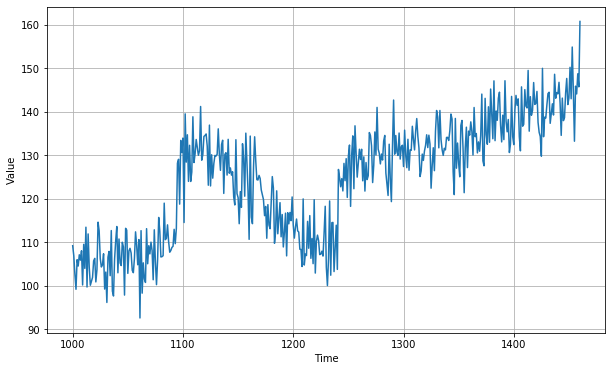

In [55]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)


In [58]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset


In [60]:
dataset = window_dataset(series, window_size, batch_size, shuffle_buufer_size)

model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(10, input_shape = [window_size], activation="relu"),
    tf.keras.layers.Dense(10, activation="relu"),
    tf.keras.layers.Dense(1)
    
])

model.compile(loss = 'mse', optimizer = tf.keras.optimizers.SGD(lr = 1e-6, momentum = 0.9))
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
model.fit(dataset, epochs = 100, verbose = 0, callbacks = [lr_schedule])


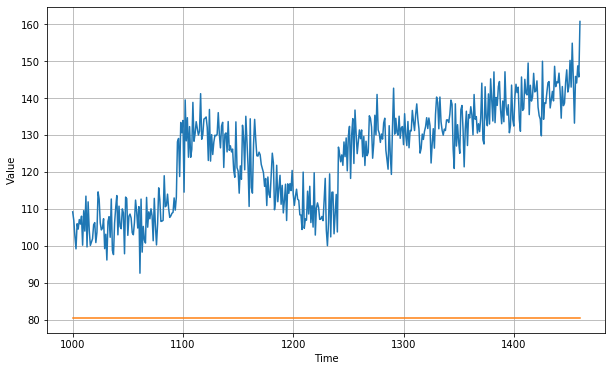

In [61]:
forecast = []
for time in range(len(series) - window_size):
      forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [52]:
print(forcast)

[array([[84.48152]], dtype=float32), array([[84.48152]], dtype=float32), array([[84.48152]], dtype=float32), array([[84.48152]], dtype=float32), array([[84.48152]], dtype=float32), array([[84.48152]], dtype=float32), array([[84.48152]], dtype=float32), array([[84.48152]], dtype=float32), array([[84.48152]], dtype=float32), array([[84.48152]], dtype=float32), array([[84.48152]], dtype=float32), array([[84.48152]], dtype=float32), array([[84.48152]], dtype=float32), array([[84.48152]], dtype=float32), array([[84.48152]], dtype=float32), array([[84.48152]], dtype=float32), array([[84.48152]], dtype=float32), array([[84.48152]], dtype=float32), array([[84.48152]], dtype=float32), array([[84.48152]], dtype=float32), array([[84.48152]], dtype=float32), array([[84.48152]], dtype=float32), array([[84.48152]], dtype=float32), array([[84.48152]], dtype=float32), array([[84.48152]], dtype=float32), array([[84.48152]], dtype=float32), array([[84.48152]], dtype=float32), array([[84.48152]], dtype=f

In [63]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

43.96695

In [66]:
random.random(100)

NameError: name 'random' is not defined